## Inpainting: Complete a Digit given a Half Image

In [2]:
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.layers import *
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
train_data = mnist.train.images
train_labels = mnist.train.labels
n_x = train_data.shape[1] # 784
n_y = train_labels.shape[1] # 10
n_z = 2
n_epoch = 20
m = 50 # batch size

In [12]:
# Encoder Q(z/X, c)
X = Input(shape=(n_x,))

# Hidden layer of the encoder
h_q = Dense(512, activation='relu')(X)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

In [26]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(n_z,), mean=0.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])
# concatenate z with c
# Here cond is the top half of the image
def split_im(im):
    return X[:, :392]
    
cond = Lambda(split_im)(X)
z_cond = concatenate([z, cond], axis=1)
#z_cond = merge([z, cond], mode='concat', concat_axis=1)

In [16]:
z_cond

<tf.Tensor 'concatenate_2/concat:0' shape=(?, 394) dtype=float32>

In [17]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z_cond)
output = decoder_out(h_p)

In [18]:
# Overall CVAE model, for reconstruction and training
vae = Model(X, output)

In [17]:
# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the representative of the gaussian
encoder = Model(X, mu)

In [25]:
# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z + 392,)) # concatenate label with z
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [27]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [35]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(train_data[:10000], train_data[:10000], batch_size=m, epochs=n_epoch)

Epoch 1/20
10000/10000 [==============================] - 7s - loss: 78.6928     
Epoch 2/20
10000/10000 [==============================] - 6s - loss: 77.4638     
Epoch 3/20
10000/10000 [==============================] - 6s - loss: 77.0730     
Epoch 4/20
10000/10000 [==============================] - 6s - loss: 76.4089     
Epoch 5/20
10000/10000 [==============================] - 6s - loss: 76.1840     
Epoch 6/20
10000/10000 [==============================] - 6s - loss: 75.9160     
Epoch 7/20
10000/10000 [==============================] - 7s - loss: 75.6803     
Epoch 8/20
10000/10000 [==============================] - 6s - loss: 75.4011     
Epoch 9/20
10000/10000 [==============================] - 6s - loss: 75.2316     
Epoch 10/20
10000/10000 [==============================] - 6s - loss: 74.6364     
Epoch 11/20
10000/10000 [==============================] - 6s - loss: 74.4343     
Epoch 12/20
10000/10000 [==============================] - 7s - loss: 74.2898     
Epoch 13/20
1

## Test Images

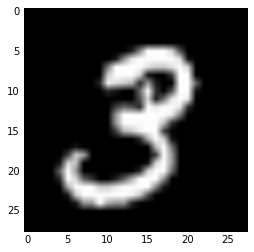

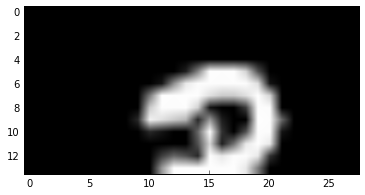

In [124]:
x = train_data[1]
plt.imshow(x.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()
y = x[:392]
plt.imshow(y.reshape(14,28), cmap='gray', vmin=0, vmax=1)

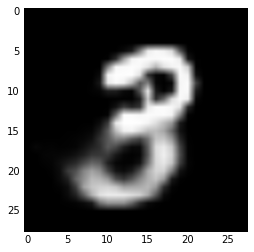

In [138]:
# we are giving y as cond
# sample z
z = np.array([np.random.normal(), np.random.normal()]).flatten()
z_concat = np.concatenate([z, y]).reshape(1,394)

x_out = decoder.predict(z_concat)

plt.imshow(x_out.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

In [42]:
z_concat.shape

(1, 394)